# Multi-armed Bandits

The expected value for action $q$ given that action $a$ is selected is given by the reward $R_t$

\begin{align}
q_*(a) := \mathbb{E}\left[R_t,A_t=a \right]
\end{align}

The action-value function if defined as
\begin{align}
Q_t(a) := \frac{\text{sum of rewards when a taken prior to t}}{\text{number of times a taken prior to t}}
\end{align}

### Multi-Armed Bandits as DM Environment

Testbed

In [1]:
!pip install dm-env numpy

In [2]:
import dm_env
from dm_env import specs
import numpy as np
from dataclasses import dataclass


@dataclass
class BaditArm:
    mean: float
    sigma: float
    rng: np.random.RandomState

    def __call__(self):
        return self.rng.normal(self.mean, self.sigma)


class MultiArmedBandit(dm_env.Environment):
    def __init__(self, k: int = 10, seed: int = 1, sigma: float = 0.5):
        self._seed = seed
        self._k = k
        self._sigma = sigma
        self._reset()

    def reset(self) -> dm_env.TimeStep:
        self._reset()
        return dm_env.restart(np.zeros(1))

    def step(self, action: int) -> dm_env.TimeStep:
        reward = self._arms[action]()
        return dm_env.termination(reward=reward, observation=None)

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(0,),
            dtype=np.float_,
            name="multi-armed-bandit",
            minimum=0,
            maximum=len(self._arms)-1,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.DiscreteArray(dtype=int, num_values=1, name="action")

    def _reset(self):
        rng = np.random.RandomState(self._seed)
        self._arms = [
            BaditArm(mean=a*10., sigma=self._sigma, rng=rng) for a in rng.random_sample((self._k))
        ]

    def __repr__(self):
        return repr(self._arms)


## $\epsilon$ greedy

When a actor is greedy, it will take the action with the highest expected reward.
But with the chance of $\epsilon$ it will choose a random action.

\begin{align}
Q_t(q) = \frac{\sum_iR_i\cdot\mathbb{1}_{A_i=a}}{\sum_i\mathbb{1}_{A_i=a}}
\end{align}

In [3]:
class BanditActor:

    def __init__(self, k: int, environment: MultiArmedBandit, epsilon: float = 0., seed: int = 1, name: str = None):
        self._environment = environment
        self._rewards = np.zeros(k, dtype=environment.observation_spec().dtype)
        self._counts = np.zeros(k, dtype=np.int32)
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._k = k
        self._q = []
        self.name = name or f'$\epsilon = {epsilon}$'

    def __call__(self):
        if self._rng.random_sample() < self._epsilon:
            # greedy
            action = self._rng.randint(0, self._k)
        else:
            action = np.argmax(self.returns)
        timestep = self._environment.step(action)
        self._rewards[action] += timestep.reward
        self._counts[action] += 1
        self._q.append(timestep.reward)

    @property
    def returns(self):
        return self._rewards / np.maximum(self._counts, 1.)

    @property
    def total_reward(self):
        return np.sum(self._rewards)

    @property
    def mean_reward(self):
        return np.mean(self._q)

    @property
    def last_reward(self):
        return self._q[-1]


In [4]:
K = 100
multi_armed_bandit = MultiArmedBandit(K)


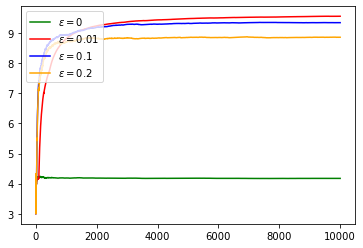

In [5]:
import matplotlib.pyplot as plt

greedies = {'green': 0, 'red': 0.01, 'blue': 0.1, 'orange': 0.2}
STEPS = 10000
x = range(STEPS)

for color, epsilon in greedies.items():
    multi_armed_bandit.reset()
    actor = BanditActor(K, multi_armed_bandit, epsilon)

    y = []
    for _ in x:
        actor()
        y.append(actor.mean_reward)

    plt.plot(x, y, color=color, label=f'$\epsilon = {epsilon}$')

plt.legend(loc='upper left')
plt.show()


## Incremental Implementation

\begin{align}
Q_{n+1} = Q_n + \frac{1}{n} \left[R_n - Q_n \right] 
\end{align}

Where $\frac{1}{n}$ is called *step size*.

## Optimistic Initial Value

Start with $Q_1(a) = 0$

In [6]:
class OptimisticBanditActor(BanditActor):
    @property
    def returns(self):
        return (self._rewards + 5) / (self._counts + 1)

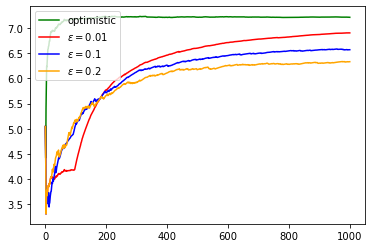

In [7]:
import matplotlib.pyplot as plt

K = 10
multi_armed_bandit = MultiArmedBandit(K)

actors = {'green': OptimisticBanditActor(K, multi_armed_bandit, 0.0, name='optimistic'),
          'red': BanditActor(K, multi_armed_bandit, 0.01),
          'blue': BanditActor(K, multi_armed_bandit, 0.1),
          'orange': BanditActor(K, multi_armed_bandit, 0.2)}
STEPS = 1000
x = range(STEPS)

for color, actor in actors.items():
    multi_armed_bandit.reset()

    y = []
    for _ in x:
        actor()
        y.append(actor.mean_reward)

    plt.plot(x, y, color=color, label=actor.name)

plt.legend(loc='upper left')
plt.show()


## Upper Confidence Bound

\begin{align}
A_t := \text{arg max}_a \left[Q_t(a) + c\sqrt{\frac{\ln t}{N_t(a)}} \right]
\end{align}

With a parameter $c > 0$.

In [8]:
class BanditActorUCB(BanditActor):
    def __init__(self, *args, c:float, name:str=None, **kwargs):
        super().__init__(*args, **kwargs)
        self._c = c
        self.name = name or f'$c = {c}$'
        self._t = 0
    
    def __call__(self):
        self._t += 1
        action = np.argmax(self.returns + self._c*np.sqrt(np.log(self._t)/ np.maximum(self._counts,1)))
            
        timestep = self._environment.step(action)
        self._rewards[action] += timestep.reward
        self._counts[action] += 1
        self._q.append(timestep.reward)

    


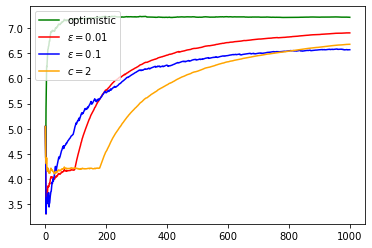

In [9]:
import matplotlib.pyplot as plt

K = 10
multi_armed_bandit = MultiArmedBandit(K)

actors = {'green': OptimisticBanditActor(K, multi_armed_bandit, 0.0, name='optimistic'),
          'red': BanditActor(K, multi_armed_bandit, 0.01),
          'blue': BanditActor(K, multi_armed_bandit, 0.1),
          'orange': BanditActorUCB(K, multi_armed_bandit, c=2)}
STEPS = 1000
x = range(STEPS)

for color, actor in actors.items():
    multi_armed_bandit.reset()

    y = []
    for _ in x:
        actor()
        y.append(actor.mean_reward)

    plt.plot(x, y, color=color, label=actor.name)

plt.legend(loc='upper left')
plt.show()
